#Importing libraries and DATA

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2022-05-21 01:23:19.083186: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-21 01:23:19.083231: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data=pd.read_csv('/home/rookie/Desktop/rookie/code/PaidProjects/fiverrAssignment/NeuralNetworkFromScratch/classification.csv')
x = np.array(data)
np.random.shuffle(x)
train , test = x[:220,:], x[220:,:]
xtrain, y_train = train[:,0:2], train[:,2]
xtest, y_test = test[:,0:2] , test[:,2]

In [3]:
m = np.mean(xtrain)
stded = np.std(xtrain)
x_train = (xtrain - m ) / stded
x_test = (xtest - m) / stded

# Neural Network from Scratch using ReLU

In [4]:
# add comments to explain the code
import math
import numpy as np


def sigmoidScalar(x): #  sigmoid function
    return 1/(1+math.exp(-x))

def sigmoidPriScal(x): # derivative of sigmoid function
    return sigmoidScalar(x)*(1-sigmoidScalar(x)) 

def reluScalar(x): # ReLU function
    if x > 0:
        return x
    else:
        return 0


def reluPriScal(x): # derivative of ReLU function
    if x > 0:
        return 1
    else:
        return 0

def tanhScalar(x): # tanh function
    return math.tanh(x)

def tanhPriScal(x): # derivative of tanh function
    return 1 - math.tanh(x)**2



sigmoid = np.vectorize(sigmoidScalar) # vectorize sigmoid function
sigmoidPrime = np.vectorize(sigmoidPriScal) # vectorize derivative of sigmoid function
relu = np.vectorize(reluScalar) # vectorize ReLU function
reluPrime = np.vectorize(reluPriScal) # vectorize derivative of ReLU function
tanh = np.vectorize(tanhScalar) # vectorize tanh function
tanhPrime = np.vectorize(tanhPriScal) # vectorize derivative of tanh function

In [5]:
class NeuralNetwork: # class for neural network
    def __init__(self, X, Y, dims, lr=1.2, iterations=3000): # constructor
        self.X = X # input
        self.Y = Y # output
        self.dims = dims # dimensions of the network
        self.lr = lr  # learning rate
        self.iterations = iterations # number of iterations
        self.length = len(self.dims)-1 # length of the network
        self.parameters = {} # parameters of the network
        self.cache = {} # cache of the network
        self.grads = {} # gradients of the network
        self.cost = 1   # cost of the network
        self.train_acc = [] # training accuracy of the network
        self.cost_list = [] # cost list of the network

    def initialize(self): # initialize parameters of the network
        np.random.seed(3) # set seed for random number generation 
        for l in range(1, len(self.dims)): # for each layer
            self.parameters['W'+str(l)] = np.random.randn(self.dims[l],
                                                      self.dims[l-1])*0.01 # initialize weights
            self.parameters['b'+str(l)] = np.zeros((self.dims[l], 1)) # initialize biases
    
    def predict(self, X): # predict the output of the network
        self.forward_propagation() # forward propagation
        return np.round(self.cache['A'+str(len(self.dims)-1)]) # return the output

    def forward_propagation(self): # forward propagation
        self.cache['A0'] = self.X # input layer
        # For last layer, ie, the output layer 3, we need to activate using sigmoid
        # For layer 1 and 2, we need to use relu
        for l in range(1, len(self.dims)-1): # for each layer
            self.cache['Z'+str(l)] = np.dot(self.parameters['W'+str(l)],
                                            self.cache['A'+str(l-1)]) + self.parameters['b'+str(l)] # compute Z
            self.cache['A'+str(l)] = relu(self.cache['Z'+str(l)]) # compute A
        l = len(self.dims)-1    # for the last layer                    
        self.cache['Z'+str(l)] = np.dot(self.parameters['W'+str(l)],
                                        self.cache['A'+str(l-1)]) + self.parameters['b'+str(l)] # compute Z
        self.cache['A'+str(l)] = sigmoid(self.cache['Z'+str(l)]) # compute A

    def compute_cost(self): # compute cost of the network
        m = self.Y.shape[0] # number of training examples
        A = self.cache['A'+str(len(self.dims)-1)] # output of the network
        self.cost = -1/m * \
            np.sum(np.multiply(self.Y, np.log(A)) +
                   np.multiply(1-self.Y, np.log(1-A))) # cost function
        self.cost = np.squeeze(self.cost) # remove the extra dimension

    def backward_propagation(self): # backward propagation
        A = self.cache['A' + str(len(self.dims) - 1)] # output of the network
        m = self.X.shape[1] # number of training examples
        self.grads['dA'+str(len(self.dims)-1) 
                   ] = np.divide(A - self.Y, (1 - A) * A) # compute dA
        # Sigmoid derivative for final layer
        l = len(self.dims)-1 # for the last layer
        self.grads['dZ' + str(l)] = self.grads['dA' + str(l)] * \
            sigmoidPrime(self.cache['Z' + str(l)]) # compute dZ
        self.grads['dW' + str(l)] = 1 / m * np.dot(self.grads['dZ' +
                                                              str(l)], self.cache['A' + str(l - 1)].T) # compute dW
        self.grads['db' + str(l)] = 1 / m * \
            np.sum(self.grads['dZ' + str(l)], axis=1, keepdims=True) # compute db
        self.grads['dA' + str(l - 1)] = np.dot(self.parameters['W' +
                                                           str(l)].T, self.grads['dZ' + str(l)]) # compute dA
        # Relu derivative for previous layers
        for l in range(len(self.dims)-2, 0, -1): # for each layer
            self.grads['dZ'+str(l)] = self.grads['dA'+str(l)] * \
                reluPrime(self.cache['Z'+str(l)]) # compute dZ
            self.grads['dW'+str(l)] = 1/m*np.dot(self.grads['dZ' +
                                                            str(l)], self.cache['A'+str(l-1)].T) # compute dW
            self.grads['db'+str(l)] = 1/m * \
                np.sum(self.grads['dZ'+str(l)], axis=1, keepdims=True) # compute db
            self.grads['dA'+str(l-1)] = np.dot(self.parameters['W' +
                                                           str(l)].T, self.grads['dZ'+str(l)]) # compute dA

    def update_parameters(self): # update parameters of the network
        for l in range(1, len(self.dims)): # for each layer
            self.parameters['W'+str(l)] = self.parameters['W'+str(l)] - \
                self.lr*self.grads['dW'+str(l)] # update W
            self.parameters['b'+str(l)] = self.parameters['b'+str(l)] - \
                self.lr*self.grads['db'+str(l)] # update b

    def train(self):    # train the network
        np.random.seed(1)   # set seed for random number generation
        self.initialize()   # initialize parameters
        for i in range(self.iterations):   # for each iteration
            self.forward_propagation() # forward propagation
            self.compute_cost() # compute cost
            self.backward_propagation() # backward propagation
            self.update_parameters() # update parameters
            if i % 100 == 0: # every 100 iterations
                print('Cost after {} iterations is {}'.format(i, self.cost))    # print cost
                # calculate prediction and accuracy for training set and append to list
                pred = self.predict(self.X) # predict the output of the network
                acc = np.sum(pred == self.Y) / self.Y.shape[0] # calculate accuracy
                self.train_acc.append(acc) # append accuracy to list
                # calculate cost for each iteration and append to list
                self.cost_list.append(self.cost) # append cost to list
        print('Final cost is {}'.format(self.cost)) # print final cost

## Neural Network using ReLU with 1 hidden layer

In [6]:
import numpy as np # import numpy
clf = NeuralNetwork(x_train.T, y_train, [2, 32, 1], lr=1, iterations=4200) # create a neural network
clf.train() # train the network

Cost after 0 iterations is 0.6931471805599453
Cost after 100 iterations is 0.3432035920165828
Cost after 200 iterations is 0.2838726060789702
Cost after 300 iterations is 0.2887076397169888
Cost after 400 iterations is 0.2928563592589176
Cost after 500 iterations is 0.2942664542204178
Cost after 600 iterations is 0.298156161923643
Cost after 700 iterations is 0.28810686239073574
Cost after 800 iterations is 0.28729333782899147
Cost after 900 iterations is 0.28356041750121797
Cost after 1000 iterations is 0.28183076137255075
Cost after 1100 iterations is 0.282939082771813
Cost after 1200 iterations is 0.2818629352643721
Cost after 1300 iterations is 0.28231107975817893
Cost after 1400 iterations is 0.28107981684106426
Cost after 1500 iterations is 0.2810321251429186
Cost after 1600 iterations is 0.2794819089519046
Cost after 1700 iterations is 0.2791849069040411
Cost after 1800 iterations is 0.27895641202846716
Cost after 1900 iterations is 0.2787941751211483
Cost after 2000 iterations 

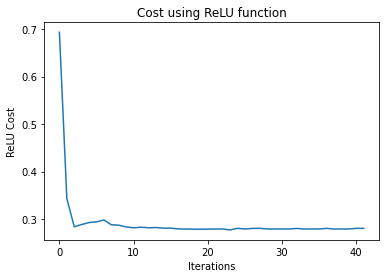

In [7]:
# plot cost vs iterations
import matplotlib.pyplot as plt # import matplotlib
plt.plot(clf.cost_list) # plot cost vs iterations
plt.title('Cost using ReLU function') # set title
plt.xlabel('Iterations') # set x label
plt.ylabel('ReLU Cost') # set y label
plt.show() # show plot

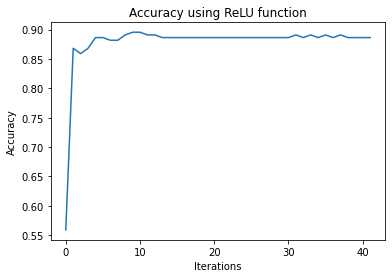

In [8]:
# plot accuracy vs iterations
plt.plot(clf.train_acc) # plot accuracy vs iterations
plt.title('Accuracy using ReLU function') # set title
plt.xlabel('Iterations') # set x label
plt.ylabel('Accuracy') # set y label
plt.show() # show plot

## Neural Network using ReLU with 2 hidden layers

In [11]:
import numpy as np # import numpy
clf = NeuralNetwork(x_train.T, y_train, [2, 32, 64,1], lr=1, iterations=4200) # create a neural network
clf.train() # train the network

Cost after 0 iterations is 0.6931471805599453
Cost after 100 iterations is 0.6861473616903819
Cost after 200 iterations is 0.6861473616903819
Cost after 300 iterations is 0.6861473616903819
Cost after 400 iterations is 0.6861473616903819
Cost after 500 iterations is 0.6861473616903819
Cost after 600 iterations is 0.6861473616903819
Cost after 700 iterations is 0.6861473616903819
Cost after 800 iterations is 0.6861473616903819
Cost after 900 iterations is 0.6861473616903819
Cost after 1000 iterations is 0.6861473616903819
Cost after 1100 iterations is 0.6861473616903819
Cost after 1200 iterations is 0.6861473616903819
Cost after 1300 iterations is 0.6861473616903819
Cost after 1400 iterations is 0.6861473616903819
Cost after 1500 iterations is 0.6861473616903819
Cost after 1600 iterations is 0.6861473616903819
Cost after 1700 iterations is 0.6861473616903819
Cost after 1800 iterations is 0.6861473616903819
Cost after 1900 iterations is 0.6861473616903819
Cost after 2000 iterations is 0.

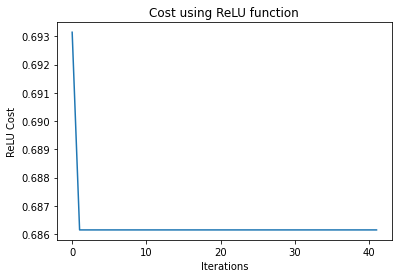

In [12]:
# plot cost vs iterations
import matplotlib.pyplot as plt # import matplotlib
plt.plot(clf.cost_list) # plot cost vs iterations
plt.title('Cost using ReLU function') # set title
plt.xlabel('Iterations') # set x label
plt.ylabel('ReLU Cost') # set y label
plt.show() # show plot

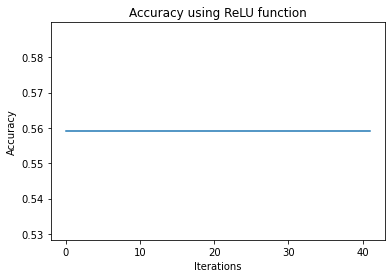

In [13]:
# plot accuracy vs iterations
plt.plot(clf.train_acc) # plot accuracy vs iterations
plt.title('Accuracy using ReLU function') # set title
plt.xlabel('Iterations') # set x label
plt.ylabel('Accuracy') # set y label
plt.show() # show plot

# Neural Network from Scratch using Tanh hypebolic

In [14]:
class NeuralNetwork: # neural network class
    def __init__(self, X, Y, dims, lr=1.2, iterations=3000): # initialize the network
        self.X = X # input data
        self.Y = Y  # output data
        # Including input layer and output layer. Let example be dims=4
        self.dims = dims # dimensions of the network
        self.lr = lr  # Learning rate
        self.iterations = iterations    # Number of iterations
        self.length = len(self.dims)-1 # length of the network
        self.parameters = {}    # To store parameters W and b for each layer
        self.cache = {}     # To store cache Z and A for each layer
        self.grads = {}     # To store dA, dZ, dW, db
        self.cost = 1       # Initial value does not matter
        self.train_acc = [] # To store training accuracy
        self.cost_list = [] # To store cost for each iteration

    def initialize(self):   # initialize parameters
        np.random.seed(3)   # set seed for random number generation
        for l in range(1, len(self.dims)):  # for each layer
            self.parameters['W'+str(l)] = np.random.randn(self.dims[l],
                                                      self.dims[l-1])*0.01  # initialize W
            self.parameters['b'+str(l)] = np.zeros((self.dims[l], 1))   # initialize b
    
    def predict(self, X):   # predict the output of the network
        self.forward_propagation()  # forward propagation
        return np.round(self.cache['A'+str(len(self.dims)-1)])  # return prediction

    def forward_propagation(self):  # forward propagation
        self.cache['A0'] = self.X   # set A0 to input data
        for l in range(1, len(self.dims)-1):    # for each layer
            self.cache['Z'+str(l)] = np.dot(self.parameters['W'+str(l)],
                                            self.cache['A'+str(l-1)]) + self.parameters['b'+str(l)] # compute Z
            self.cache['A'+str(l)] = tanh(self.cache['Z'+str(l)])   # compute A
        l = len(self.dims)-1    # for last layer
        self.cache['Z'+str(l)] = np.dot(self.parameters['W'+str(l)],
                                        self.cache['A'+str(l-1)]) + self.parameters['b'+str(l)]     # compute Z
        self.cache['A'+str(l)] = sigmoid(self.cache['Z'+str(l)])    # compute A

    def compute_cost(self):  # compute cost
        m = self.Y.shape[0] # number of training examples
        A = self.cache['A'+str(len(self.dims)-1)]   # output of the network
        self.cost = -1/m * \
            np.sum(np.multiply(self.Y, np.log(A)) +
                   np.multiply(1-self.Y, np.log(1-A)))  # compute cost
        self.cost = np.squeeze(self.cost)   # remove dimensions of size 1

    def backward_propagation(self): # backward propagation
        A = self.cache['A' + str(len(self.dims) - 1)]   # output of the network
        m = self.X.shape[1]     # number of training examples
        self.grads['dA'+str(len(self.dims)-1)
                   ] = np.divide(A - self.Y, (1 - A) * A)   # compute dA
        # Sigmoid derivative for final layer
        l = len(self.dims)-1    # for last layer
        self.grads['dZ' + str(l)] = self.grads['dA' + str(l)] * \
            sigmoidPrime(self.cache['Z' + str(l)])  # compute dZ
        self.grads['dW' + str(l)] = 1 / m * np.dot(self.grads['dZ' +
                                                              str(l)], self.cache['A' + str(l - 1)].T)  # compute dW
        self.grads['db' + str(l)] = 1 / m * \
            np.sum(self.grads['dZ' + str(l)], axis=1, keepdims=True)        # compute db
        self.grads['dA' + str(l - 1)] = np.dot(self.parameters['W' +
                                                           str(l)].T, self.grads['dZ' + str(l)])    # compute dA
        # tanh derivative for previous layers
        for l in range(len(self.dims)-2, 0, -1):    # for each layer
            self.grads['dZ'+str(l)] = self.grads['dA'+str(l)] * \
                tanhPrime(self.cache['Z'+str(l)])   # compute dZ
            self.grads['dW'+str(l)] = 1/m*np.dot(self.grads['dZ' +
                                                            str(l)], self.cache['A'+str(l-1)].T)    # compute dW
            self.grads['db'+str(l)] = 1/m * \
                np.sum(self.grads['dZ'+str(l)], axis=1, keepdims=True)  # compute db
            self.grads['dA'+str(l-1)] = np.dot(self.parameters['W' +
                                                           str(l)].T, self.grads['dZ'+str(l)])  # compute dA

    def update_parameters(self):    # update parameters
        for l in range(1, len(self.dims)):  # for each layer
            self.parameters['W'+str(l)] = self.parameters['W'+str(l)] - \
                self.lr*self.grads['dW'+str(l)]  # update W
            self.parameters['b'+str(l)] = self.parameters['b'+str(l)] - \
                self.lr*self.grads['db'+str(l)] # update b

    def train(self):    # train the network
        np.random.seed(1)   # set seed for random number generation
        self.initialize()   # initialize parameters
        for i in range(self.iterations):    # for each iteration
            self.forward_propagation()  # forward propagation
            self.compute_cost() # compute cost
            self.backward_propagation() # backward propagation
            self.update_parameters()    # update parameters
            if i % 100 == 0:    # print cost every 100 iterations
                print('Cost after {} iterations is {}'.format(i, self.cost))
                # calculate prediction and accuracy for training set and append to list
                pred = self.predict(self.X)
                acc = np.sum(pred == self.Y) / self.Y.shape[0]
                self.train_acc.append(acc)
                # calculate cost for each iteration and append to list
                self.cost_list.append(self.cost)
        print('Final cost is {}'.format(self.cost))

## Neural Network with Tanh using 4 hidden layers

In [15]:
import numpy as np # import numpy
clf = NeuralNetwork(x_train.T, y_train, [2, 128 , 64 , 64 ,32,1], lr=1, iterations=5000)    # create classifier
clf.train()   # train the classifier

Cost after 0 iterations is 0.6931470852150396
Cost after 100 iterations is 0.6861470519142242
Cost after 200 iterations is 0.6861468101934104
Cost after 300 iterations is 0.6861465383543204
Cost after 400 iterations is 0.6861462192440725
Cost after 500 iterations is 0.686145829049809
Cost after 600 iterations is 0.6861453325253777
Cost after 700 iterations is 0.6861446743021025
Cost after 800 iterations is 0.6861437618554457
Cost after 900 iterations is 0.686142429209208
Cost after 1000 iterations is 0.6861403511999523
Cost after 1100 iterations is 0.6861368115219314
Cost after 1200 iterations is 0.6861299430374094
Cost after 1300 iterations is 0.6861133811264655
Cost after 1400 iterations is 0.686050604088854
Cost after 1500 iterations is 0.6843944786757113
Cost after 1600 iterations is 0.3066593041169926
Cost after 1700 iterations is 0.2889711169832598
Cost after 1800 iterations is 0.2883000472830156
Cost after 1900 iterations is 0.2872293846245867
Cost after 2000 iterations is 0.286

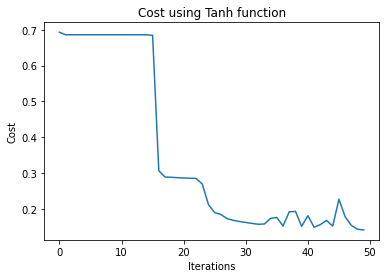

In [16]:
# plot cost vs iterations
import matplotlib.pyplot as plt # import matplotlib
plt.plot(clf.cost_list) # plot cost vs iterations
plt.title('Cost using Tanh function')   # plot title
plt.xlabel('Iterations')    # x-axis label
plt.ylabel('Cost')  # y-axis label
plt.show()  # show plot

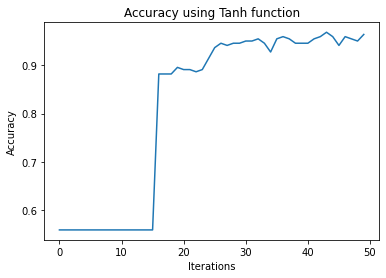

In [17]:
# plot accuracy vs iterations
plt.plot(clf.train_acc)     # plot accuracy vs iterations
plt.title('Accuracy using Tanh function')       # plot title

plt.xlabel('Iterations')    # x-axis label
plt.ylabel('Accuracy')  # y-axis label
plt.show()  # show plot

## Neural Network with Tanh using 2 hidden layers

In [18]:
import numpy as np  # import numpy
clf = NeuralNetwork(x_train.T, y_train, [2, 64 ,32 ,1], lr=1, iterations=5000)  # create classifier
clf.train() # train the classifier

Cost after 0 iterations is 0.6931321464835285
Cost after 100 iterations is 0.289416525108049
Cost after 200 iterations is 0.289342866218966
Cost after 300 iterations is 0.28926460112637015
Cost after 400 iterations is 0.2891611455628078
Cost after 500 iterations is 0.28899635732864387
Cost after 600 iterations is 0.2886966717394523
Cost after 700 iterations is 0.2881238219048507
Cost after 800 iterations is 0.28702897138369937
Cost after 900 iterations is 0.2839178146741237
Cost after 1000 iterations is 0.2583953524203744
Cost after 1100 iterations is 0.20160218070113886
Cost after 1200 iterations is 0.18517537957444055
Cost after 1300 iterations is 0.18928348985210453
Cost after 1400 iterations is 0.18132538089563166
Cost after 1500 iterations is 0.17616125317578737
Cost after 1600 iterations is 0.17236007093844496
Cost after 1700 iterations is 0.16926765109443792
Cost after 1800 iterations is 0.16641974618054414
Cost after 1900 iterations is 0.16341024092229894
Cost after 2000 iterat

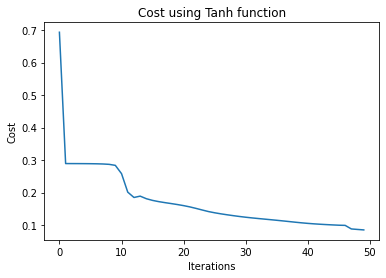

In [19]:
# plot cost vs iterations   
import matplotlib.pyplot as plt # import matplotlib
plt.plot(clf.cost_list) # plot cost vs iterations
plt.title('Cost using Tanh function')   # plot title
plt.xlabel('Iterations')    # x-axis label
plt.ylabel('Cost')  # y-axis label
plt.show()  # show plot

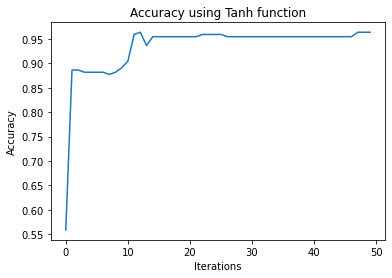

In [20]:
# plot accuracy vs iterations
plt.plot(clf.train_acc)    # plot accuracy vs iterations
plt.title('Accuracy using Tanh function')    # plot title
plt.xlabel('Iterations')    # x-axis label
plt.ylabel('Accuracy')  # y-axis label
plt.show()  # show plot

## Neural Network with Tanh using 1 hidden layers

In [21]:
import numpy as np  # import numpy  
clf = NeuralNetwork(x_train.T, y_train, [2, 32 ,1], lr=1, iterations=5000)  # create classifier
clf.train() # train the classifier

Cost after 0 iterations is 0.6932269822346225
Cost after 100 iterations is 0.28941344825875465
Cost after 200 iterations is 0.2893399689570825
Cost after 300 iterations is 0.2892581018826501
Cost after 400 iterations is 0.28912166354266017
Cost after 500 iterations is 0.28835142479608245
Cost after 600 iterations is 0.28039158294564737
Cost after 700 iterations is 0.2536081761832586
Cost after 800 iterations is 0.2282960167087205
Cost after 900 iterations is 0.21432021815408844
Cost after 1000 iterations is 0.20638871326741387
Cost after 1100 iterations is 0.20088644418599652
Cost after 1200 iterations is 0.19658928508143314
Cost after 1300 iterations is 0.19310442207278897
Cost after 1400 iterations is 0.19034374891213188
Cost after 1500 iterations is 0.18820284175928323
Cost after 1600 iterations is 0.1865240805143262
Cost after 1700 iterations is 0.1851665942318264
Cost after 1800 iterations is 0.18403097811180366
Cost after 1900 iterations is 0.1830531390793457
Cost after 2000 iter

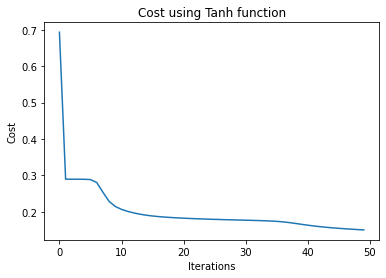

In [22]:
# plot cost vs iterations
import matplotlib.pyplot as plt # import matplotlib 
plt.plot(clf.cost_list) # plot cost vs iterations
plt.title('Cost using Tanh function')   # plot title
plt.xlabel('Iterations')    # x-axis label
plt.ylabel('Cost')  # y-axis label
plt.show()  # show plot

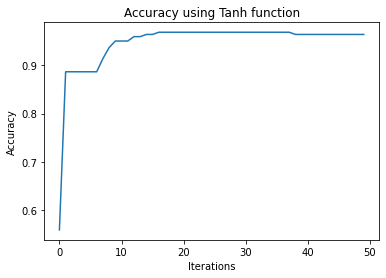

In [23]:
# plot accuracy vs iterations
plt.plot(clf.train_acc)   # plot accuracy vs iterations
plt.title('Accuracy using Tanh function')   # plot title
plt.xlabel('Iterations')    # x-axis label
plt.ylabel('Accuracy')      # y-axis label
plt.show()  # show plot